LightGBM : XGBoost 이후로 나온 최신 부스팅 모델
- 이미지의 경우가 아니면 거의 사용가능한 모델
- 이상거래 탐지: 신용카드 내역 분석

이상거래예측


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/fraud.csv' )

In [3]:
pd.options.display.max_columns=None
df.head(2)
# is_fraud가 0이면 정상 1이면 이상거래
# 이상거래를 찾는 것으로 분류

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [4]:
df.info(show_counts=True)   # 데이터가 너무 크면 df.info() 시 결측치를 확인할 수 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [5]:
round(df.describe(),2)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1.852394e+06,1852394.00,1852394.00,1852394.00
mean,4.173860e+17,70.06,48813.26,38.54,-90.23,88643.67,1.358674e+09,38.54,-90.23,0.01
std,1.309115e+18,159.25,26881.85,5.07,13.75,301487.62,1.819508e+07,5.11,13.76,0.07
min,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.800429e+14,9.64,26237.00,34.67,-96.80,741.00,1.343017e+09,34.74,-96.90,0.00
50%,3.521417e+15,47.45,48174.00,39.35,-87.48,2443.00,1.357089e+09,39.37,-87.44,0.00
75%,4.642255e+15,83.10,72042.00,41.94,-80.16,20328.00,1.374581e+09,41.96,-80.25,0.00
max,4.992346e+18,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95,1.00


- 데이터 클리닝
  - 불필요한 변수들을 제외, 특성을 고려해서
  - 중복의미를 가지는 데이터
    -

In [6]:
# street, city, state, zip은 위도와 경도가 데이터에 포함되어 있으므로 사용할 필요가 없음
# merchant도 상점의 이미 수치형인 위도, 경도가 포함되어 있기 때문에 사용할 필요가 없음
# 고객의 이름, 직업도 상관없음

In [7]:
# drop list
drop_list = ['merchant','first',	'last','street'	,'city',	'state',	'zip','job','unix_time']
data = df.drop(drop_list,axis=1)
data.head(2)

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,trans_num,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0


In [8]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

In [9]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1852394 non-null  datetime64[ns]
 1   cc_num                 1852394 non-null  int64         
 2   category               1852394 non-null  object        
 3   amt                    1852394 non-null  float64       
 4   gender                 1852394 non-null  object        
 5   lat                    1852394 non-null  float64       
 6   long                   1852394 non-null  float64       
 7   city_pop               1852394 non-null  int64         
 8   dob                    1852394 non-null  object        
 9   trans_num              1852394 non-null  object        
 10  merch_lat              1852394 non-null  float64       
 11  merch_long             1852394 non-null  float64       
 12  is_fraud               18523

In [10]:
# 전처리 : 피처엔지니어링
# 고객의 소비패턴에서 벗어난 결재 찾아내서.. 판단
# Z-score : 표준점   (값 - 평균)/std  다양한데이터를 동일한  척도로 비교할수 있다. -- StandardSacle
# cc_num별 amt의 평균과 표준편차
amt_info = data.groupby('cc_num')['amt'].agg(['mean','std']).reset_index()
amt_info

,cc_num,mean,std
0,60416207185,59.257796,142.869746
1,60422928733,65.483159,92.042844
2,60423098130,96.376084,1000.693872
3,60427851591,107.487550,131.014534
4,60487002085,64.096925,153.207660
...,...,...,...
994,4958589671582726883,67.205600,137.504101
995,4973530368125489546,75.789148,258.847061
996,4980323467523543940,70.709484,119.903167
997,4989847570577635369,93.008939,128.396760


In [11]:
# 기존데이터와 merge
zdata = data.merge(amt_info, on = 'cc_num', how='left')

# 특성값(amt) 평균 표준편차 -- z-score
zdata['amt_z_score'] = (zdata['amt'] - zdata['mean']) / zdata['std']

In [12]:
zdata[['amt','mean','std','amt_z_score']].head()

,amt,mean,std,amt_z_score
0,4.97,89.408743,127.530101,-0.662108
1,107.23,56.078113,159.201852,0.321302
2,220.11,69.924272,116.688602,1.287064
3,45.00,80.090040,280.077880,-0.125287
4,41.96,95.341146,94.322842,-0.565941


In [13]:
# mean, std --> z-score를 구하는데 필요한 데이터 이므로 삭제
zdata = zdata.drop(['mean','std'],axis=1)

In [14]:
# 관점을 넓혀서 범주형을 확대
category_info = zdata.groupby(['cc_num','category'])['amt'].agg(['mean','std']).reset_index()
num_category_zdata = zdata.merge(category_info, on=['cc_num','category'], how='left')

In [15]:
num_category_zdata['cat_z_score'] = (num_category_zdata['amt'] - num_category_zdata['mean']) / num_category_zdata['std']
num_category_zdata = num_category_zdata.drop(['mean','std'],axis=1)

In [16]:
# 거리 : 사용자가 주로 반경 20km이내에서 소비  200km
# 위경도를 이용해서 거리 측정 geopy

In [17]:
from geopy.distance import distance
# geopy.distance((위,경),(위,경) )

In [18]:
num_category_zdata['distance'] = \
num_category_zdata.apply(
    lambda row:
      distance((row['merch_lat'], row['merch_long']), (row['lat'], row['long'])).km, axis=1
    )

In [19]:
num_category_zdata.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,trans_num,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score,distance
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,-0.662108,-0.688297,78.773821
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,0.321302,0.317631,30.216618
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,1.287064,2.872509,108.102912
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,-0.125287,-1.050197,95.685115
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,-0.565941,1.312866,77.702395


In [20]:
# cc_num별로 distance에 대한 mean std 구하고
# distance_z_score 저장
distance_info = num_category_zdata.groupby('cc_num')['distance'].agg(['mean','std'])
temp = num_category_zdata.merge(distance_info, on='cc_num', how='left')
num_category_zdata['distance_z_score'] = (temp['distance'] - temp['mean']) / temp['std']

In [21]:
# 나이
# 년 월 일 --> 공휴일여부

In [22]:
num_category_zdata['age'] = 2024- pd.to_datetime(num_category_zdata['dob']).dt.year

In [23]:
# 불필요한 컬럼제거 : 피처엔지니어링을 위한 컬럼
drop_list = ['cc_num','lat','long','merch_lat','merch_long','dob','trans_num']
data = num_category_zdata.drop(drop_list,axis=1)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   category               object        
 2   amt                    float64       
 3   gender                 object        
 4   city_pop               int64         
 5   is_fraud               int64         
 6   amt_z_score            float64       
 7   cat_z_score            float64       
 8   distance               float64       
 9   distance_z_score       float64       
 10  age                    int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(2)
memory usage: 155.5+ MB


In [25]:
data = pd.get_dummies(data, columns=['category','gender'],drop_first=True)

In [26]:
data = data.set_index('trans_date_trans_time')

In [27]:
data

,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,4.97,3495,0,-0.662108,-0.688297,78.773821,0.030974,36,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2019-01-01 00:00:44,107.23,149,0,0.321302,0.317631,30.216618,-1.475224,46,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2019-01-01 00:00:51,220.11,4154,0,1.287064,2.872509,108.102912,1.160572,62,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2019-01-01 00:01:16,45.00,1939,0,-0.125287,-1.050197,95.685115,0.818063,57,False,True,False,False,False,False,False,False,False,False,False,False,False,True
2019-01-01 00:03:06,41.96,99,0,-0.565941,1.312866,77.702395,0.064037,38,False,False,False,False,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:59:07,43.77,519,0,-0.167639,-0.047862,77.032467,0.052081,58,False,False,False,False,True,False,False,False,False,False,False,False,False,True
2020-12-31 23:59:09,111.84,28739,0,0.364619,1.163822,100.023736,0.693848,25,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2020-12-31 23:59:15,86.88,3684,0,-0.015209,0.440137,80.887812,0.288293,43,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [28]:
print(data.columns)

Index(['amt', 'city_pop', 'is_fraud', 'amt_z_score', 'cat_z_score', 'distance',
       'distance_z_score', 'age', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M'],
      dtype='object')


In [29]:
from datetime import date
import holidays

# 국가 코드로 공휴일 정보 불러오기 (예: 미국)
us_holidays = holidays.US()
# 특정 날짜가 공휴일인지 확인
target_date = date(2024, 7, 4)

def check_holiday(target_date):
  if target_date in us_holidays:
      return 1
  else:
      return 0

# data['isHoliday'] = data.trans_date_trans_time.apply(lambda row : check_holiday(row))
data['isHoliday'] = data.index.map(check_holiday)

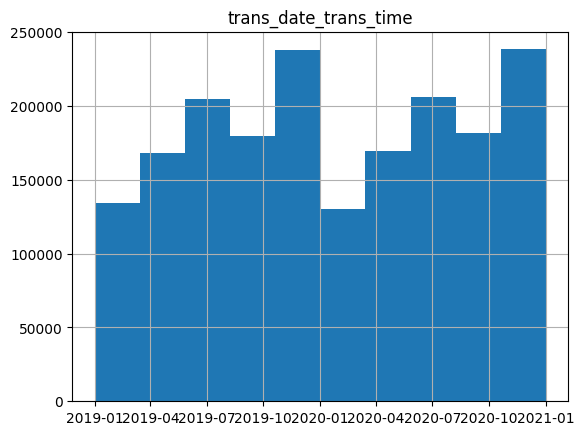

In [30]:
# 데이터 분리
import matplotlib.pyplot as plt
pd.DataFrame(data.index).hist()
plt.show()

In [31]:
# 2020-07-01
train = data[data.index < '2020-07-01']
test = data[data.index >= '2020-07-01']
len(train) / len(data), len(test) / len(data)

(0.7162261376359457, 0.2837738623640543)

In [32]:
X_train = train.drop('is_fraud', axis=1)
X_test = test.drop('is_fraud', axis=1)
y_train = train['is_fraud']
y_test = test['is_fraud']

In [33]:
import lightgbm as lgb

In [34]:
model_1 = lgb.LGBMClassifier()
# 학습
model_1.fit(X_train,y_train)
# 정확도
model_1.score(X_test,y_test)

[LightGBM] [Info] Number of positive: 7639, number of negative: 1319094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 1326733, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005758 -> initscore=-5.151434
[LightGBM] [Info] Start training from score -5.151434


0.9962675564670006

In [35]:
1319094 / (7639+1319094)

0.9942422476866106

In [36]:
pred_1 = model_1.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score

In [38]:
accuracy_score(y_test, pred_1)

0.9962675564670006

In [39]:
confusion_matrix(y_test,pred_1)

array([[522619,   1030],
       [   932,   1080]])

In [40]:
# 1030 1종 오류(거짓양성)  정상거래를 잘못 감지
# 932 2종 오류(거짓음성) 이상거래를 잘못 감지
# 1080 참 양성 : 정상거래를 정상으로 감지

In [41]:
print(classification_report(y_test, pred_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.51      0.54      0.52      2012

    accuracy                           1.00    525661
   macro avg       0.76      0.77      0.76    525661
weighted avg       1.00      1.00      1.00    525661



In [42]:
print(model_1.classes_)
proba_1 = model_1.predict_proba(X_test)
proba_1

[0 1]


array([[9.99953925e-01, 4.60745480e-05],
       [9.99947112e-01, 5.28882303e-05],
       [1.00000000e+00, 0.00000000e+00],
       ...,
       [9.99888770e-01, 1.11229668e-04],
       [9.99840115e-01, 1.59885435e-04],
       [9.99879563e-01, 1.20437469e-04]])

In [43]:
proba_1 = proba_1[:,1]  # 이상거래 1에대한 값만 추출

In [44]:
# 임계치 threashold  0.2 0.8 구분해서 confusion matrix 분석
proba_int1 = (proba_1>0.2).astype('int')
proba_int2 = (proba_1>0.8).astype('int')

In [45]:
print(confusion_matrix(y_test, proba_int1))

[[521692   1957]
 [   733   1279]]


In [46]:
print(classification_report(y_test, proba_int1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.40      0.64      0.49      2012

    accuracy                           0.99    525661
   macro avg       0.70      0.82      0.74    525661
weighted avg       1.00      0.99      1.00    525661



In [47]:
print(confusion_matrix(y_test, proba_int2))
print(classification_report(y_test, proba_int2))

[[523046    603]
 [  1274    738]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.55      0.37      0.44      2012

    accuracy                           1.00    525661
   macro avg       0.77      0.68      0.72    525661
weighted avg       1.00      1.00      1.00    525661



In [48]:
roc_auc_score(y_test,proba_int1), roc_auc_score(y_test,proba_int2)

(0.8159743242448682, 0.6828238350300717)

- 하이퍼 파라메터 튜닝
  - 그리드서치, 랜덤 그리드 서치

In [49]:
from sklearn.model_selection import RandomizedSearchCV

In [50]:
params = {
    'n_estimators' : [100,500,1000],              # 반복횟수
    'learning_rate' : [0.01, 0.05, 0.1, 0.3],     # 학습률(보폭)
    'lambda_l1' : [0,10,20,30,50],                # L1 정규화
    'lambda_l2' : [0,10,20,30,50],                # L2 정규화
    'max_depth' : [5, 10, 15, 20],                # 최대 깊이
    'subsample' : [0.6, 0.8, 1]                   # 서브 샘플의 비율
}

# lgb.LGBMClassifier(lambda_l1 = 0)

In [51]:
# 피처셀렉션
# L1 정규화 피처셀렉션의 역할을 어느정도 해줌 - 불필요한 변수를 자동으로 학습에서 배제
  # 절대값 사용
# 회귀분석 : 모든 피처를 다 사용, L2(라쏘)회귀를 사용하면 좋음
  # 제곱을 사용

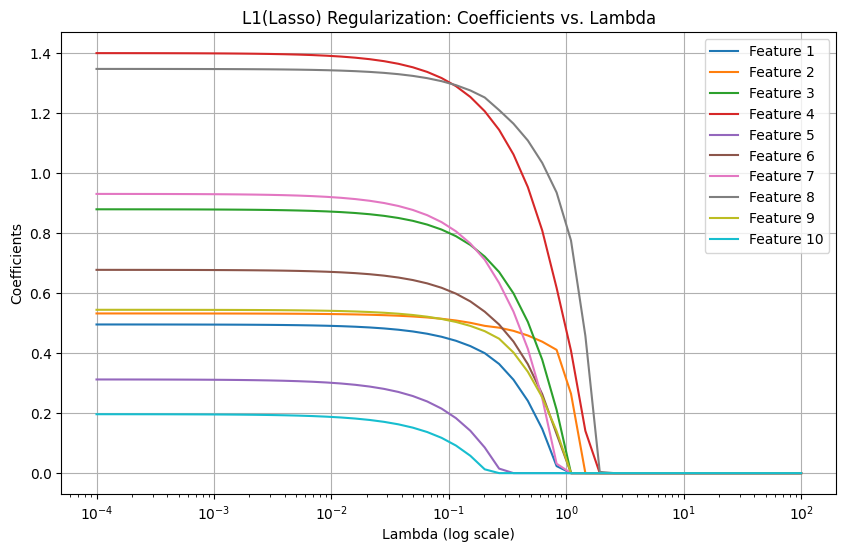

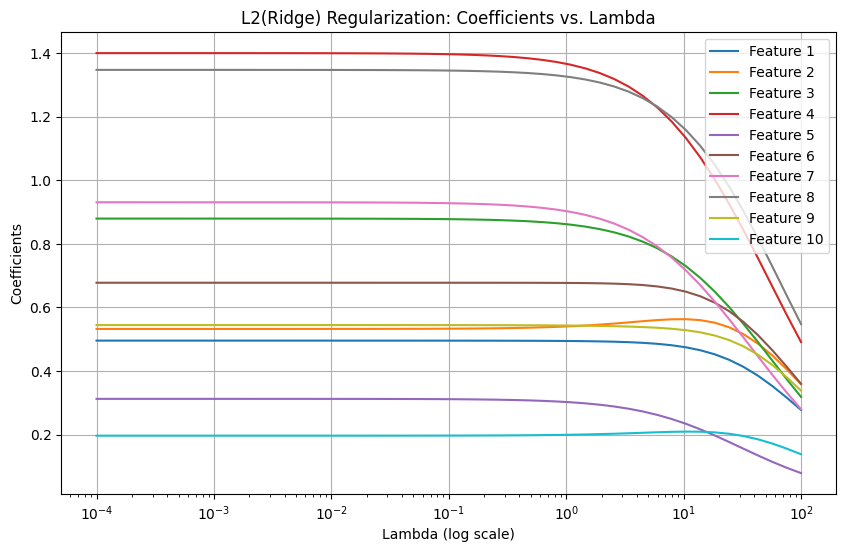

In [52]:
# L1규제는 규제 강도가 높아지면 특정 규제 강도 시점에서 특정 피처가 0이 되어서
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
# 예제 데이터 생성
np.random.seed(0)
X = np.random.rand(50, 10)  # 특성 행렬 생성
y = np.dot(X, np.array([1.5, 2.0, 3.0, 4.2, 1.0, 2.5, 3.5, 4.0, 2.0, 1.0])) + np.random.normal(size=50)  # 타겟 생성
# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# L1(Lasso) 정규화와 L2(Ridge) 정규화를 적용할 람다(λ) 값 범위 설정
lambda_values = np.logspace(-4, 2, 50)  # 10^-4 ~ 10^2 사이의 50개 로그 스케일 람다 값
# 모델 훈련 및 계수 추출
coefficients_lasso = []
coefficients_ridge = []
for lambda_val in lambda_values:
    # Lasso 모델 훈련
    lasso_model = Lasso(alpha=lambda_val, max_iter=10000)
    lasso_model.fit(X_scaled, y)
    coefficients_lasso.append(lasso_model.coef_)
    # Ridge 모델 훈련
    ridge_model = Ridge(alpha=lambda_val)
    ridge_model.fit(X_scaled, y)
    coefficients_ridge.append(ridge_model.coef_)
# 시각화: 람다(λ) 값에 따른 계수의 변화를 플로팅
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, coefficients_lasso)
plt.xscale('log')
plt.title('L1(Lasso) Regularization: Coefficients vs. Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficients')
plt.legend(['Feature {}'.format(i) for i in range(1, X.shape[1] + 1)])
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, coefficients_ridge)
plt.xscale('log')
plt.title('L2(Ridge) Regularization: Coefficients vs. Lambda')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficients')
plt.legend(['Feature {}'.format(i) for i in range(1, X.shape[1] + 1)])
plt.grid(True)
plt.show()

In [54]:
model_2 = lgb.LGBMClassifier()
rs = RandomizedSearchCV(model_2, param_distributions=params, n_iter=30, scoring="roc_auc", n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7639, number of negative: 1319094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1636
[Light

{'subsample': 0.6,
 'n_estimators': 500,
 'max_depth': 10,
 'learning_rate': 0.1,
 'lambda_l2': 50,
 'lambda_l1': 0}

In [55]:
best_model = rs.best_estimator_
best_predict_proba = best_model.predict_proba(X_test)

# best_model = rs.best_model
# best_predict_proba = best_model.predict_proba(X_test)

# 1일때의 상황   이상거래
proba_1 = best_predict_proba[:,1]
proba_int1 = (proba_1>0.2).astype('int')
proba_int2 = (proba_1>0.8).astype('int')

# 각각에 대해서 confusion metrix를 구한다.

[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
